In [1]:
# Simulation module for Korup reactor conditions
# https://www-sciencedirect-com.ezproxy.neu.edu/science/article/pii/S0021951712002795

In [16]:
import cantera as ct
import numpy as np
import signal
import os
import copy
import scipy.interpolate
import logging

import pandas as pd

import matplotlib.pyplot as plt

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [17]:
N_REACTORS = 1001
MIN_SIM_DIST = -0.005  # in meters
MAX_SIM_DIST = 0.025  # in meters
TOTAL_PFR_LEN = MAX_SIM_DIST - MIN_SIM_DIST
INDIVIDUAL_CSTR_LEN = TOTAL_PFR_LEN / N_REACTORS
dist_array = np.linspace(MIN_SIM_DIST, MAX_SIM_DIST, N_REACTORS)

In [18]:
# first, load data
UNCERTAINTY_REPO = os.environ['UNCERTAINTY_REPO']
pt_data = os.path.join(UNCERTAINTY_REPO, './cpox_pt/korup/korup_experiment.csv')
df = pd.read_csv(pt_data)
distances = df['Distance (mm)'] / 1000.0
exp_Ts = df['Temperature C'] + 273.15
temperature_function = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')
temperature_profile = temperature_function(dist_array)
use_temperature_profile = True

In [19]:
TIMEOUT_SECONDS = 30

In [20]:
# set up the catalyst on/off indices
CAT_ON_INDEX = np.argmin(np.abs(dist_array - 0))
CAT_OFF_INDEX = np.argmin(np.abs(dist_array - 0.02))

In [21]:
# ----------------------- Parameters specific to Korup experiment -----------------------
REACTOR_DIAMETER = 0.0162
CROSS_SECTION_AREA = (REACTOR_DIAMETER / 2.0) ** 2.0 * np.pi
POROSITY = 0.7

FOAM_MASS_GRAMS = 3.9  # catalyst mass (Al2O3+Pt)	3.90 g
PT_MASS_GRAMS = 0.0109 * FOAM_MASS_GRAMS  # Pt loading	1.09 wt.%
CAT_AREA = 0.015 * PT_MASS_GRAMS            # 0.015 m2 g−1
FOAM_VOLUME = 1e-6  # m3

CAT_AREA_PER_VOL = CAT_AREA / FOAM_VOLUME  # 0.015 m2 g−1
# says geometric surface area is: Geometric surface area (from μ-CT)	4650 m2 m3

# Reactor in autothermal operation with a gas feed of CH4/O2/Ar = 1184/592/2224 mln min−1 (C/O = 1.0).
FLOW_RATE_SLPM = 4.0  # slpm
FLOW_RATE = FLOW_RATE_SLPM * 0.001 / 60  # m^3/s
velocity = FLOW_RATE / CROSS_SECTION_AREA  # m/s
residence_time = INDIVIDUAL_CSTR_LEN / velocity # unit in s
individual_cstr_vol = CROSS_SECTION_AREA * INDIVIDUAL_CSTR_LEN * POROSITY
individual_cstr_cat_area = CAT_AREA_PER_VOL * individual_cstr_vol
T_INLET = 1120  # K  -- won't matter if using the temperature profile
x_CH4 = 1184 / 4000  # inlet mole fraction of methane
x_O2 = 592 / 4000
x_Ar = 1.0 - x_CH4 - x_O2
P_INLET = ct.one_atm  # Pa

In [22]:

# Plotting settings
FIG_HEIGHT = 6.0
FIG_WIDTH = 12.0


In [23]:
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated_mod.yaml'

gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

In [24]:
def get_i_thing(ref_composition, phase):
    """Helper function for getting the index of a species in a Cantera phase given its composition"""
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False, f"Could not find species with composition {ref_composition} in phase {phase.name}"

# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)

In [25]:
# Initialize the reactor
X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = FLOW_RATE * gas.density_mass
gas.TPX = T_INLET, P_INLET, X
surf.TP = T_INLET, P_INLET

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages

In [26]:
use_temperature_profile

True

In [27]:
surf_kinetics_perturb = {}
surf_thermo_perturb = {}

# create a new reactor
if use_temperature_profile:
    r = ct.IdealGasReactor(gas, energy='off')
else:
    r = ct.IdealGasReactor(gas, energy='on')
r.volume = individual_cstr_vol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
if ct.__version__ in ['2.6.0']:
    v = ct.PressureController(r, downstream, master=m, K=1e-5)
else:
    v = ct.PressureController(r, downstream, primary=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# we already know the shape of the output arrays, so we should preallocate them for speed
gas_out = np.zeros((N_REACTORS, gas.n_species)) + np.nan
# Don't need to store these other outputs, but we could
surf_out = np.zeros((N_REACTORS, surf.n_species)) + np.nan
gas_rates = np.zeros((N_REACTORS, gas.n_reactions)) + np.nan
surf_rates = np.zeros((N_REACTORS, surf.n_reactions)) + np.nan
T_array = np.zeros(N_REACTORS) + np.nan


# start in the non-catalyst region
surf.set_multiplier(0.0)

for n in range(N_REACTORS):
    signal.alarm(TIMEOUT_SECONDS)  # Set the alarm for the timeout

    # Set the state of the reservoir to match that of the previous reactor
    if use_temperature_profile:
        gas.TDY = temperature_profile[n], r.thermo.DP[0], r.thermo.Y
        # surf.TD = temperature_profile[n], surf.TD[1]
        r.syncState()
        upstream.syncState()
    else:
        gas.TDY = r.thermo.TDY
        upstream.syncState()
    
    sim.reinitialize()
    if n == CAT_ON_INDEX:
        # turn the surface reactions on as we enter the catalyst region
        surf.set_multiplier(1.0)

        # apply kinetic perturbations to the surface reactions
        if surf_kinetics_perturb:
            for index in surf_kinetics_perturb.keys():
                surf.set_multiplier(surf_kinetics_perturb[index], index)
                logging.debug(f"Set multiplier of surface reaction {surf.reactions()[index].equation} to {surf_kinetics_perturb[index]}")

    elif n == CAT_OFF_INDEX:
        # turn the surface reactions off as we exit the catalyst region
        surf.set_multiplier(0.0)

    try:
        sim.initial_time = 0.0
        sim.advance(sim.time + 1e4 * residence_time)
        # add timeout handling here if the simulation takes too long
    except (ct.CanteraError, ct._utils.CanteraError, TimeoutException) as e:
        signal.alarm(0)
    #except (ct.CanteraError, ct._utils.CanteraError) as e:
        logging.error(f"Cantera error at reactor {n}: {e}")
        # return gas_out, surf_out, gas_rates, surf_rates

    
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    # gas_out[n, :] = 1000 * 60 * kmole_flow_rate * gas.X.copy()  # molar flow rate in moles/minute
    gas_out[n, :] = gas.X.copy()  # molar flow rate in moles/minute
    surf_out[n, :] = surf.X.copy()
    gas_rates[n, :] = gas.net_rates_of_progress
    surf_rates[n, :] = surf.net_rates_of_progress
    T_array[n] = surf.T
    
    # Reset the alarm
    signal.alarm(0)


/tmp/ipykernel_1644/3510150158.py:6: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasReactor(gas, energy='off')
/tmp/ipykernel_1644/3510150158.py:10: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  upstream = ct.Reservoir(gas, name='upstream')
/tmp/ipykernel_1644/3510150158.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor.

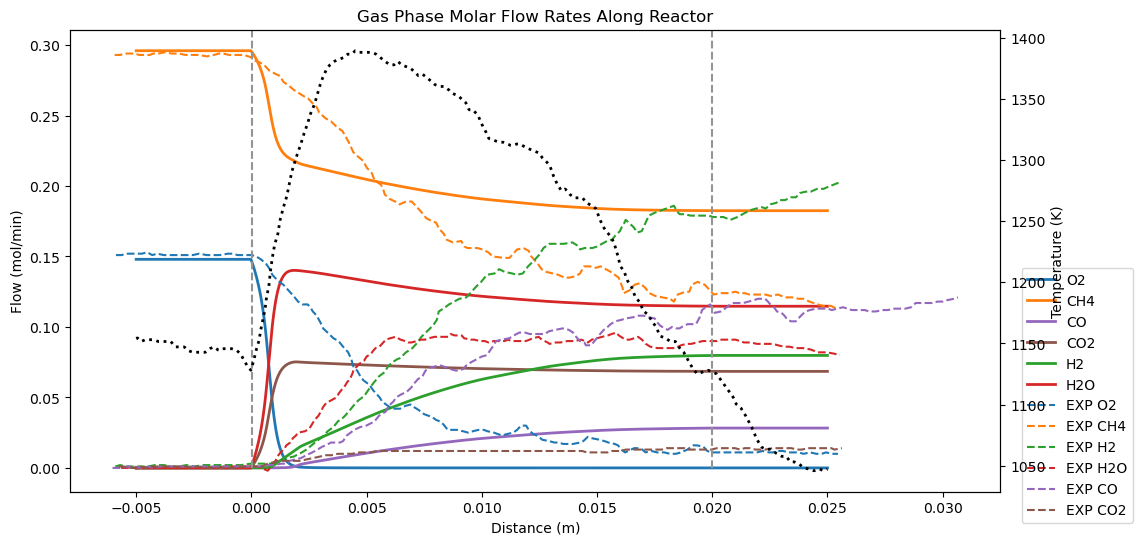

In [28]:
# Get indices of key species
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)

# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(FIG_HEIGHT)
fig.set_figwidth(FIG_WIDTH)

# Simulation Results
plt.plot(dist_array, gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO], label='CO', color=colors[4], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO2], label='CO2', color=colors[5], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2O], label='H2O', color=colors[3], linewidth=linewidth2)

# # Experimental data
plt.plot(df['Distance (mm) O2'].values / 1000.0, df['O2'].values, linestyle='dashed', label='EXP O2', color=colors[0])
plt.plot(df['Distance (mm) CH4'].values / 1000.0, df['CH4'].values, linestyle='dashed', label='EXP CH4', color=colors[1])
plt.plot(df['Distance (mm) H2'].values / 1000.0, df['H2'].values, linestyle='dashed', label='EXP H2', color=colors[2])
plt.plot(df['Distance (mm) H2O'].values / 1000.0, df['H2O'].values, linestyle='dashed', label='EXP H2O', color=colors[3])
plt.plot(df['Distance (mm) CO'].values / 1000.0, df['CO'].values, linestyle='dashed', label='EXP CO', color=colors[4])
plt.plot(df['Distance (mm) CO2'].values / 1000.0, df['CO2'].values, linestyle='dashed', label='EXP CO2', color=colors[5])

ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
plt.plot([dist_array[CAT_ON_INDEX], dist_array[CAT_ON_INDEX]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[CAT_OFF_INDEX], dist_array[CAT_OFF_INDEX]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.ylim(ylim)
plt.title('Gas Phase Molar Flow Rates Along Reactor')

ax2 = ax1.twinx()
if T_array is not None:
    ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
    ax2.set_ylabel('Temperature (K)')
    ax2.yaxis.get_major_formatter().set_useOffset(False)
else:
    ax2.plot(dist_array, temperature_profile, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
    
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
# ax1.set_ylim((-0.005686988947011412, 0.1))
# ax1.set_xlim((-0.0004950495049504951, 0.010396039603960397))
